<a href="https://colab.research.google.com/github/LoPA607/IE643_project/blob/main/Zstar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --upgrade diffusers transformers accelerate safetensors


In [ ]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def show(img, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()


Device: cuda


In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16, safety_checker=None
).to(device)
pipe.enable_attention_slicing()
print("Pipeline loaded.")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Pipeline loaded.


Upload style (extreme/noisy) image:


Saving Istanbul_blur1.png to Istanbul_blur1 (5).png
Upload content (clean) image:


Saving clean.jpg to clean (5).jpg


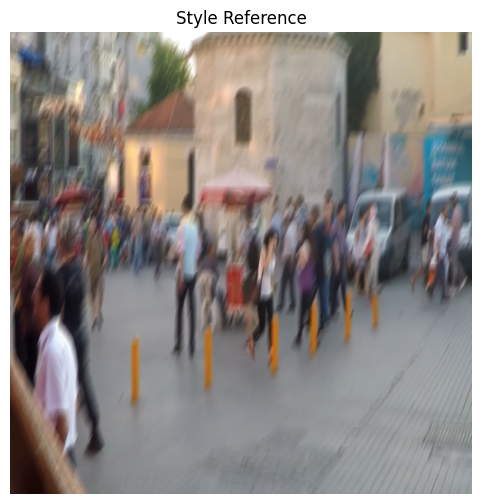

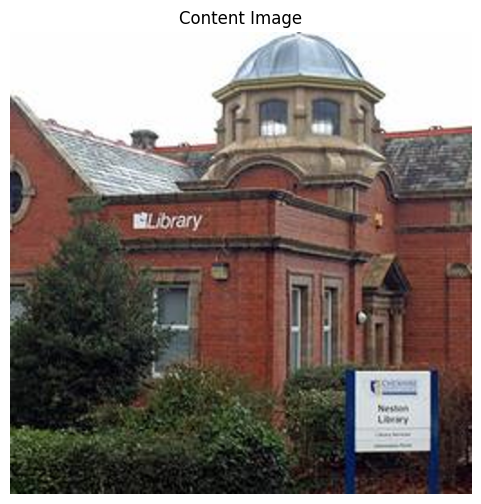

In [ ]:
print("Upload style (extreme/noisy) image:")
u = files.upload()
style_path = list(u.keys())[0]
style_img = Image.open(style_path).convert("RGB").resize((512,512))

print("Upload content (clean) image:")
u2 = files.upload()
content_path = list(u2.keys())[0]
content_img = Image.open(content_path).convert("RGB").resize((512,512))

show(style_img, "Style Reference")
show(content_img, "Content Image")


In [ ]:
attention_maps_style = {}

def hook_fn(name):
    def hook(module, input, output):
        attention_maps_style[name] = output[0].detach().clone()
    return hook

registered = []
for name, module in pipe.unet.named_modules():
    if "cross_attn" in name or "attn2" in name:
        h = module.register_forward_hook(hook_fn(name))
        registered.append(h)

neutral_prompt = "a photo"
_ = pipe(prompt=neutral_prompt, image=style_img, strength=0.7, num_inference_steps=20)

for h in registered:
    h.remove()

print("Collected style attention maps:", len(attention_maps_style))
for k in list(attention_maps_style.keys())[:5]:
    print(k, attention_maps_style[k].shape)


  0%|          | 0/14 [00:00<?, ?it/s]

Collected style attention maps: 96
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q torch.Size([4096, 320])
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k torch.Size([77, 320])
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_v torch.Size([77, 320])
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_out.0 torch.Size([4096, 320])
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_out.1 torch.Size([4096, 320])


In [ ]:
# Example: map layer names to alpha
alpha_map = {
    "down_blocks.0": 0.2,  # early layers - preserve edges/structure
    "down_blocks.1": 0.2,
    "mid_block": 0.3,       # middle layers - moderate style
    "up_blocks.0": 0.7,     # late layers - inject textures/colors
    "up_blocks.1": 0.8
}


In [ ]:
orig_forward = pipe.unet.forward

def reweighted_forward(*args, **kwargs):
    out = orig_forward(*args, **kwargs)
    try:
        main = out[0] if isinstance(out, tuple) else out
        for name, s_att in attention_maps_style.items():
            # get layer-specific alpha
            alpha = alpha_map.get(name, 0.4)  # default 0.4
            sig = s_att.mean(dim=1, keepdim=True)  # style signature
            sig_up = sig.expand(-1, main.shape[1], -1, -1)
            main = (1-alpha)*main + alpha*sig_up
        if isinstance(out, tuple):
            out = (main,) + out[1:]
        else:
            out = main
    except Exception as e:
        pass
    return out

pipe.unet.forward = reweighted_forward


  0%|          | 0/30 [00:00<?, ?it/s]

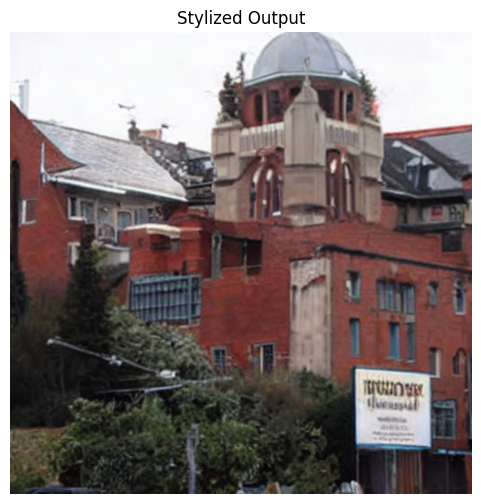

Saved: stylized_output.png


In [ ]:
from torch import Generator
seed = 47
generator = Generator(device=device).manual_seed(seed)

strength = 0.6
guidance = 7.5
steps = 50

result = pipe(
    prompt=neutral_prompt,
    image=content_img,
    strength=strength,
    guidance_scale=guidance,
    num_inference_steps=steps,
    generator=generator
).images[0]

show(result, "Stylized Output")
result.save("stylized_output.png")
print("Saved: stylized_output.png")
